**CATEGORIZING THE VARIOUS SECTIONS IN A RESUME USING BERT**

In [1]:
import pandas as pd
import numpy as np
import re
from tqdm import tqdm
import gc
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

DATASET

In [2]:
input_file_path = 'sections_dataset.txt'
output_file_path = 'cleaned_sections_dataset.txt'

def clean_line(line):
    line = re.sub(r'[^\w\s\t]', '', line)
    line = re.sub(r'[\u2013\u2014\u2022\u25CF]', ' ', line)
    line = re.sub(r'\s+', ' ', line)
    return line.strip()

with open(input_file_path, 'r', encoding='utf-8') as infile, open(output_file_path, 'w', encoding='utf-8') as outfile:
    for line in infile:
        cleaned_line = clean_line(line)
        outfile.write(cleaned_line + '\n')

with open(output_file_path, 'r', encoding='utf-8') as infile:
    lines = [line.strip().split(' ', 2) for line in infile]

df = pd.DataFrame(lines, columns=['section', 'category', 'text'])
print(df.head(20))

category_list = list(df['category'].unique())
print("\nUnique sections: ", category_list)

    section    category                                               text
0      meta      others                                 Jitesh Vishwakarma
1      meta      others                    EmailId jvishwakarma123gmailcom
2      meta      others                          Contact Number 9960902548
3    header  experience                               PROFESSIONAL SUMMARY
4   content  experience  4 years of technical experience in implementat...
5   content  experience  Having Domain Experience in PAYMENT AUTOMOBILE...
6   content  experience  Experienced in developing Web based applicatio...
7   content  experience  Experience in designing developing and deployi...
8   content  experience                    Exposure to AGILE methodologies
9   content  experience  Hands on exposure to multiple Application Serv...
10  content  experience  Expertise in backend procedure development for...
11   header   knowledge                                   TECHNICAL SKILLS
12  content   knowledge  

In [3]:
class TextClassificationDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

In [4]:
def prepare_data(df):
    unique_categories = df['category'].unique()
    category_to_idx = {cat: idx for idx, cat in enumerate(unique_categories)}
    idx_to_category = {idx: cat for cat, idx in category_to_idx.items()}

    print("Categories:", category_to_idx)
    print(idx_to_category)

    # Label encoding
    labels = df['category'].map(category_to_idx).values
    texts = df['text'].values

    train_texts, temp_texts, train_labels, temp_labels = train_test_split(
        texts, labels, test_size=0.2, random_state=42
    )
    val_texts, test_texts, val_labels, test_labels = train_test_split(
        temp_texts, temp_labels, test_size=0.5, random_state=42
    )

    print(f"Train size: {len(train_texts)}")
    print(f"Validation size: {len(val_texts)}")
    print(f"Test size: {len(test_texts)}")

    return (train_texts, train_labels,
            val_texts, val_labels,
            test_texts, test_labels,
            category_to_idx, idx_to_category)

TRAINING

In [5]:
def train_model(model, train_loader, val_loader, device, num_epochs=5):
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        # Training
        model.train()
        total_train_loss = 0

        train_progress = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}')
        for batch in train_progress:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            optimizer.zero_grad()

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            loss = outputs.loss
            total_train_loss += loss.item()

            loss.backward()
            optimizer.step()

            del outputs
            gc.collect()

            train_progress.set_postfix({'training_loss': '{:.3f}'.format(loss.item())})

        avg_train_loss = total_train_loss / len(train_loader)

        # Validation
        model.eval()
        total_val_loss = 0
        val_predictions = []
        val_true_labels = []

        with torch.no_grad():
            for batch in tqdm(val_loader, desc='Validation'):
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['label'].to(device)

                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    labels=labels
                )

                loss = outputs.loss
                total_val_loss += loss.item()

                predictions = torch.argmax(outputs.logits, dim=-1)
                val_predictions.extend(predictions.cpu().numpy())
                val_true_labels.extend(labels.cpu().numpy())

                del outputs
                gc.collect()

        avg_val_loss = total_val_loss / len(val_loader)
        val_accuracy = np.mean(np.array(val_predictions) == np.array(val_true_labels))

        print(f'\nEpoch {epoch + 1}:')
        print(f'\nAverage training loss: {avg_train_loss:.3f}')
        print(f'Average validation loss: {avg_val_loss:.3f}')
        print(f'Validation Accuracy: {val_accuracy:.3f}')

        # Save the best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), 'fine-tuned_BERT_resume-sections.pt')
            print("Saved the best model!")

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_texts, train_labels, val_texts, val_labels, test_texts, test_labels, category_to_idx, idx_to_category = prepare_data(df)

# BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=len(category_to_idx)
).to(device)

train_dataset = TextClassificationDataset(train_texts, train_labels, tokenizer)
val_dataset = TextClassificationDataset(val_texts, val_labels, tokenizer)
test_dataset = TextClassificationDataset(test_texts, test_labels, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)
test_loader = DataLoader(test_dataset, batch_size=8)

Categories: {'others': 0, 'experience': 1, 'knowledge': 2, 'project': 3, 'education': 4}
{0: 'others', 1: 'experience', 2: 'knowledge', 3: 'project', 4: 'education'}
Train size: 32000
Validation size: 4000
Test size: 4000


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Train the model
train_model(model, train_loader, val_loader, device)

Validation: 100%|██████████| 500/500 [02:00<00:00,  4.14it/s]



Epoch 1:

Average training loss: 0.455
Average validation loss: 0.419
Validation Accuracy: 0.861
Saved the best model!


Validation: 100%|██████████| 500/500 [01:57<00:00,  4.24it/s]



Epoch 2:

Average training loss: 0.366
Average validation loss: 0.439
Validation Accuracy: 0.862


Validation: 100%|██████████| 500/500 [01:57<00:00,  4.26it/s]



Epoch 3:

Average training loss: 0.296
Average validation loss: 0.448
Validation Accuracy: 0.864


Validation: 100%|██████████| 500/500 [02:00<00:00,  4.13it/s]



Epoch 4:

Average training loss: 0.236
Average validation loss: 0.475
Validation Accuracy: 0.864


Validation: 100%|██████████| 500/500 [02:04<00:00,  4.01it/s]


Epoch 5:

Average training loss: 0.195
Average validation loss: 0.505
Validation Accuracy: 0.860


TESTING

In [8]:
# Test the model
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=len(category_to_idx)
).to(device)

model.load_state_dict(torch.load('fine-tuned_BERT_resume-sections.pt', map_location=torch.device('cpu')))
model.eval()
test_predictions = []
test_true_labels = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc='Testing'):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        predictions = torch.argmax(outputs.logits, dim=-1)

        test_predictions.extend(predictions.cpu().numpy())
        test_true_labels.extend(labels.cpu().numpy())

        del outputs
        gc.collect()

test_accuracy = np.mean(np.array(test_predictions) == np.array(test_true_labels))
print(f'\nTest Accuracy: {test_accuracy:.3f}')

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\hp\AppData\Local\Temp\ipykernel_10936\1137006330.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serializati


Test Accuracy: 0.859



Confusion Matrix:
[[ 873   96   27    1   21]
 [  66 1676   83    0   40]
 [  10  106  294    0   13]
 [   2   43    0   24    2]
 [  16   33    7    0  567]]


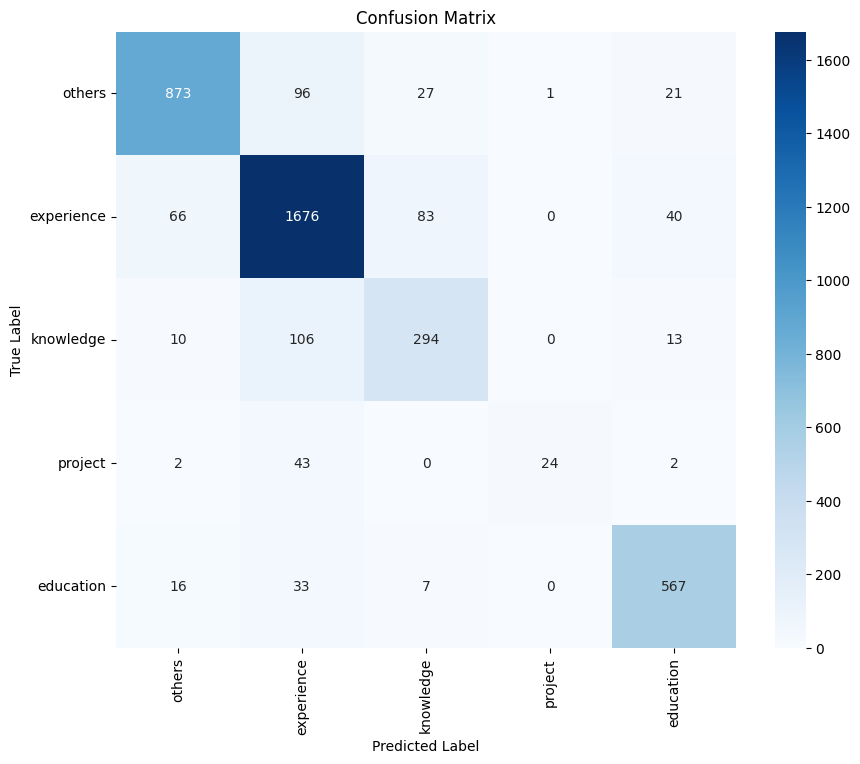


Classification Report:
              precision    recall  f1-score   support

      others       0.90      0.86      0.88      1018
  experience       0.86      0.90      0.88      1865
   knowledge       0.72      0.70      0.71       423
     project       0.96      0.34      0.50        71
   education       0.88      0.91      0.90       623

    accuracy                           0.86      4000
   macro avg       0.86      0.74      0.77      4000
weighted avg       0.86      0.86      0.86      4000



In [22]:
# Confusion matrix
cm = confusion_matrix(test_true_labels, test_predictions)
print('\nConfusion Matrix:')
print(cm)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(np.arange(len(idx_to_category)) + 0.5, list(idx_to_category.values()), rotation=90)
plt.yticks(np.arange(len(idx_to_category)) + 0.5, list(idx_to_category.values()), rotation=0)
plt.show()

# Classification report
report = classification_report(test_true_labels, test_predictions, target_names=list(idx_to_category.values()))
print('\nClassification Report:')
print(report)

USER INPUT

In [26]:
def predict_category(text, model, tokenizer, category_to_idx, idx_to_category, device):
    model.eval()
    encoding = tokenizer(
        text,
        add_special_tokens=True,
        max_length=64,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )

    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        prediction = torch.argmax(outputs.logits, dim=-1)

    predicted_category = idx_to_category[prediction.item()]
    return predicted_category

In [28]:
print("\nExample predictions:")
example_texts = [
    "4 years of technical experience in UI/UX design",
    "Contact Number: 9995689397",
    "B.Tech in Computer Science Engineering"
]

model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=len(category_to_idx)
).to(device)

model.load_state_dict(torch.load('fine-tuned_BERT_resume-sections.pt', map_location=torch.device('cpu')))

for text in example_texts:
    text = clean_line(text)
    predicted_category = predict_category(text, model, tokenizer, category_to_idx, idx_to_category, device)
    print(f"\nText: {text}")
    print(f"Predicted category: {predicted_category}")


Example predictions:


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\hp\AppData\Local\Temp\ipykernel_10936\2267328651.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serializat


Text: 4 years of technical experience in UIUX design
Predicted category: experience

Text: Contact Number 9995689397
Predicted category: others

Text: BTech in Computer Science Engineering
Predicted category: education
